In [1]:
!pip install keras

In [2]:
!pip install --upgrade tensorflow

In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv(r"C:\Users\86130\00.Project\03.Datasets\Merged_SectorType1209.csv")

In [6]:
data.head()

,Unnamed: 0,SectorType,AvgMaxPower,AvgMinPower,date,max temperature,min temperature
0,0,Large industrial electricity,117888.3300,51526.5690,1/1/2019,12.0,7.0
1,1,business electricity,64027.8582,23758.7970,1/1/2019,12.0,7.0
2,2,general industry,6179.9364,4093.0467,1/1/2019,12.0,7.0
3,3,general industry,10711.9704,3971.5308,1/2/2019,11.0,6.0
4,4,business electricity,75467.2143,20231.6265,1/2/2019,11.0,6.0


In [7]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
type_mapping = {
    'Large industrial electricity': 0,
    'business electricity': 1,
    'general industry': 2,
    'non-general industry': 3
}

In [9]:
data['type'] = data['SectorType'].map(type_mapping)

In [10]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [11]:
data.head()

,SectorType,AvgMaxPower,AvgMinPower,max temperature,min temperature,type
date,,,,,,
2019-01-01,Large industrial electricity,117888.3300,51526.5690,12.0,7.0,0
2019-01-01,business electricity,64027.8582,23758.7970,12.0,7.0,1
2019-01-01,general industry,6179.9364,4093.0467,12.0,7.0,2
2019-01-02,general industry,10711.9704,3971.5308,11.0,6.0,2
2019-01-02,business electricity,75467.2143,20231.6265,11.0,6.0,1


In [12]:
data = data[data['SectorType'] == 'Large industrial electricity']
data.head()

,SectorType,AvgMaxPower,AvgMinPower,max temperature,min temperature,type
date,,,,,,
2019-01-01,Large industrial electricity,117888.3300,51526.5690,12.0,7.0,0
2019-01-02,Large industrial electricity,126843.7914,63638.4294,11.0,6.0,0
2019-01-03,Large industrial electricity,130286.1294,102048.2754,15.0,9.0,0
2019-01-04,Large industrial electricity,133018.6344,104466.0762,17.0,12.0,0
2019-01-05,Large industrial electricity,133504.4784,99507.3528,17.0,12.0,0


In [13]:
# 选择需要的列
features = data[['AvgMinPower','max temperature', 'min temperature' ]].values
targets = data[['AvgMaxPower']].values

In [14]:
# 数据标准化
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

In [15]:
# 创建时间序列数据
def create_sequences(input_data, output_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        X.append(input_data[i:(i + time_steps)])
        y.append(output_data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(features_scaled, targets_scaled, time_steps)

In [30]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# LSTM 模型构建函数
def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))  # 输出层有两个神经元，一个用于最大平均电力负荷，另一个用于最小平均电力负荷
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 创建 KerasRegressor 包装器
model = KerasRegressor(model=create_lstm_model, verbose=0)

# 定义网格搜索参数
param_grid = {
    'model__units': [20,40, 50],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [10,16, 32],
    'epochs': [20,30,40]
}

# 创建 GridSearchCV 对象
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# 进行网格搜索
grid_result = grid.fit(X, y)

# 打印最佳参数和最佳分数
print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'batch_size': 10, 'epochs': 40, 'model__optimizer': 'rmsprop', 'model__units': 40}
Best Score: 0.7162309100619199


In [16]:
from sklearn.model_selection import train_test_split

# 假设 X 是您的特征数据，y 是您的目标数据
# X 和 y 需要是 NumPy 数组或类似数组的结构

# 设置划分比例，例如，80% 训练数据和 20% 测试数据
test_size = 0.25

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# 输出划分结果
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (726, 5, 3)
Test set size: (242, 5, 3)


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(units=40, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # 假设我们有两个输出
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [26]:
history = model.fit(X_train, y_train, epochs=40, batch_size=10, verbose=1, validation_split=0.1)

Epoch 1/40
66/66 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 2/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 3/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 4/40
66/66 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0105
Epoch 5/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 6/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0104
Epoch 7/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0108
Epoch 8/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 9/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0112
Epoch 10/40
66/66 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 11/40
66/66 [

In [27]:
# 进行预测
y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

8/8 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.04986027578836073
Mean Squared Error (MSE): 0.004722357011791211
Root Mean Squared Error (RMSE): 0.0687194078248002
R^2 Score: 0.8464986763717003


In [28]:
mape_max = np.mean(np.abs((y_test - y_pred) / y_pred)) * 100

# Print the MAPE
print(f'MAPE: {mape_max}%')

MAPE: 7.90941302167046%


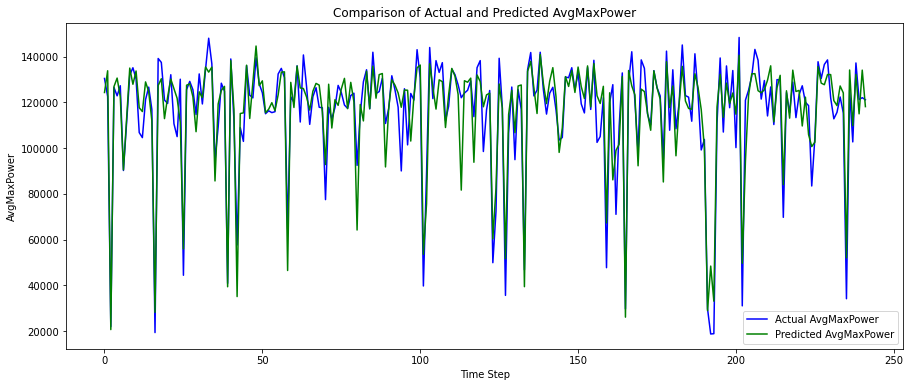

In [29]:
import matplotlib.pyplot as plt

# We will plot the true values and the predictions to see how they differ.
# Assuming y_test and y_pred are already defined and have the same shapes.

# Convert the scaled values back to the original scale for plotting
y_test_original = scaler_targets.inverse_transform(y_test)
y_pred_original = scaler_targets.inverse_transform(y_pred)

# Plotting the first target (AvgMaxPower)
plt.figure(figsize=(15, 6))
plt.plot(y_test_original[:, 0], label='Actual AvgMaxPower', color='blue')
plt.plot(y_pred_original[:, 0], label='Predicted AvgMaxPower', color='green')
plt.title('Comparison of Actual and Predicted AvgMaxPower')
plt.xlabel('Time Step')
plt.ylabel('AvgMaxPower')
plt.legend()
plt.show()

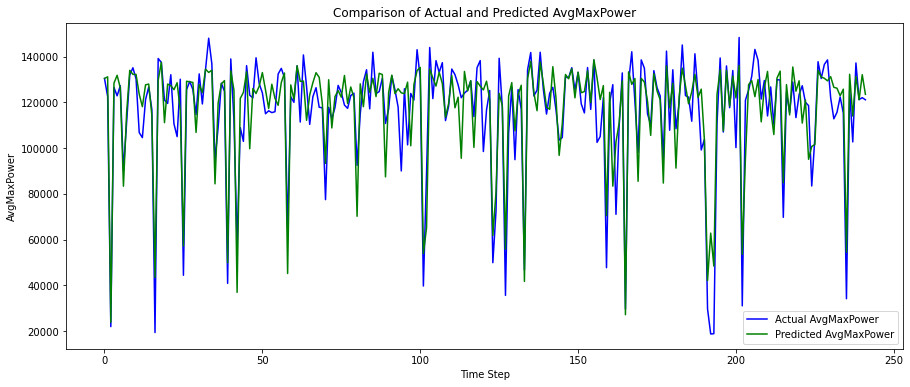

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 1080x432 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

# We will plot the true values and the predictions to see how they differ.
# Assuming y_test and y_pred are already defined and have the same shapes.

# Convert the scaled values back to the original scale for plotting
y_test_original = scaler_targets.inverse_transform(y_test)
y_pred_original = scaler_targets.inverse_transform(y_pred)

# Plotting the first target (AvgMaxPower)
plt.figure(figsize=(15, 6))
plt.plot(y_test_original[:, 0], label='Actual AvgMaxPower', color='blue')
plt.plot(y_pred_original[:, 0], label='Predicted AvgMaxPower', color='green')
plt.title('Comparison of Actual and Predicted AvgMaxPower')
plt.xlabel('Time Step')
plt.ylabel('AvgMaxPower')
plt.legend()
plt.show()

# Plotting the second target (AvgMinPower)
plt.figure(figsize=(15, 6))
plt.plot(y_test_original[:, 1], label='Actual AvgMinPower', color='blue')
plt.plot(y_pred_original[:, 1], label='Predicted AvgMinPower', color='green')
plt.title('Comparison of Actual and Predicted AvgMinPower')
plt.xlabel('Time Step')
plt.ylabel('AvgMinPower')
plt.legend()
plt.show()

In [24]:
future_temp =pd.read_csv(r"C:\Users\86130\00.Project\03.Datasets\temp.csv")
future_temp.head()

,Max temperature,Min temperature
0,36,28
1,36,27
2,36,28
3,35,27
4,33,27


In [25]:
# 对未来的温度数据进行与训练数据相同的标准化处理
future_temp_scaled = scaler_features.transform(future_temp)

In [26]:
# 使用最后的 time_steps 天数据来初始化预测
last_steps = features_scaled[-time_steps:]
X_last_steps = last_steps.reshape((1, time_steps, last_steps.shape[1]))

In [27]:
# 预测未来 30 天
future = []
for i in range(30): 
    # 获取下一个时间步的特征（包括温度）
    next_step_features = future_temp_scaled[i].reshape((1, 1, 2))
    
    # 预测下一个时间步
    y_hat = model.predict(X_last_steps)
    future.append(y_hat[0])
    
    # 更新 X_last_steps 以包括预测出的最新目标和下一个时间步的特征
    X_last_steps = np.append(X_last_steps[:, 1:, :], next_step_features, axis=1)
# 反标准化预测结果
future = scaler_targets.inverse_transform(future)

1/1 [==============================] - 0s 26ms/step


In [28]:
print("Future:", future)

Future: [[125715.56812309  94123.0084579 ]
 [125427.39066161  93229.13163252]
 [125776.72444609  92765.49336722]
 [125669.214301    92567.68949037]
 [126212.92691656  92976.12990881]
 [125795.62905514  93386.82386839]
 [126118.03729995  93450.44467297]
 [126387.47598228  93789.79736299]
 [126022.19634336  94280.11644237]
 [126144.64863558  94121.65216   ]
 [125921.38921755  94270.68495543]
 [125387.32964797  93622.99358738]
 [124645.43284143  93252.85641271]
 [123869.09578221  92847.17032231]
 [123351.65411459  92127.57429942]
 [122623.06733981  92050.07752401]
 [122564.39846538  91658.65690537]
 [122448.841206    91330.94751117]
 [121695.58068709  91738.00381022]
 [120333.56731873  91852.70488034]
 [119944.49545253  91403.17906858]
 [120268.81510518  90530.5230888 ]
 [120631.26690785  90347.34636316]
 [120719.57569564  90559.88867719]
 [120205.79974169  90524.09632337]
 [120190.34264906  90359.30960618]
 [119306.59145154  90662.80734401]
 [118628.05912408  90405.59066376]
 [118256.137

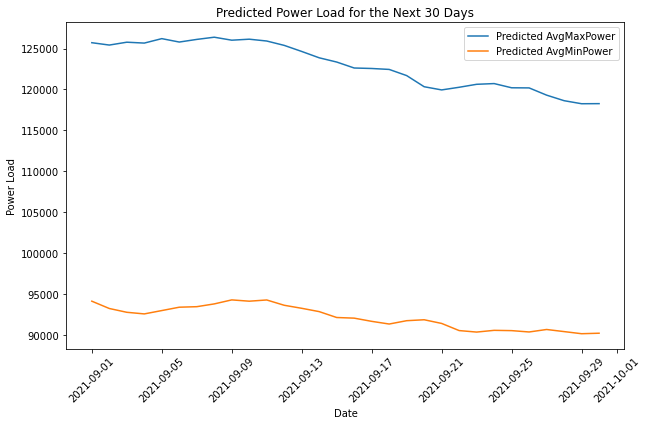

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# 创建日期序列
predicted_dates = pd.date_range(start=data.index[-1], periods=31, closed='right')

# 绘制预测数据
plt.figure(figsize=(10, 6))
plt.plot(predicted_dates, future[:, 0], label='Predicted AvgMaxPower')  # 第一列为 AvgMaxPower
plt.plot(predicted_dates, future[:, 1], label='Predicted AvgMinPower')  # 第二列为 AvgMinPower

# 设置图表标题和标签
plt.title('Predicted Power Load for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Power Load')
plt.legend()
plt.xticks(rotation=45)  # 旋转X轴标签以便清楚地显示日期
plt.show()